<div style=" background-color: #F3E0BE;" >
<h1 style="margin: auto; padding: 20px 0; color:#000000; text-align: center">PROJET 10 DATA ANALYST</h1>
<h2 style="margin: auto; padding: 20px 0; color:#000000; text-align: center">Détectez des faux billets avec R ou Python </h2>


## A. IMPORTATIONS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore, shapiro, t
from scipy.stats import levene

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import neighbors, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report,
                             confusion_matrix, auc)
import joblib
import statsmodels.api as sm


In [2]:
billets = pd.read_csv("C:\\p9\\P10\\billets.csv", sep=";", decimal=',')

###  DEFINITIONS DES VARIABLES

In [3]:
billets.head()

is_genuine diagonal height_left height_right margin_low margin_up  length
0        True   171.81      104.86       104.95       4.52      2.89  112.83
1        True   171.46      103.36       103.66       3.77      2.99  113.09
2        True   172.69      104.48        103.5        4.4      2.94  113.16
3        True   171.36      103.91       103.94       3.62      3.01  113.51
4        True   171.73      104.28       103.46       4.04      3.48  112.54

In [4]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_genuine    1500 non-null   bool  
 1   diagonal      1500 non-null   object
 2   height_left   1500 non-null   object
 3   height_right  1500 non-null   object
 4   margin_low    1463 non-null   object
 5   margin_up     1500 non-null   object
 6   length        1500 non-null   object
dtypes: bool(1), object(6)
memory usage: 71.9+ KB


In [5]:
# Valeurs manquantes moins de 3% de la Base mais à traiter
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [6]:
# Convertir toutes les colonnes en type numérique
billets = billets.apply(pd.to_numeric, errors='coerce')

In [7]:
billets['is_genuine'].replace([False,True], [0,1], inplace=True)
# Vérifier le résultat
print(billets.dtypes)


is_genuine        int64
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object


Text(0.5, 1.0, 'Taux des vrais et faux billets')

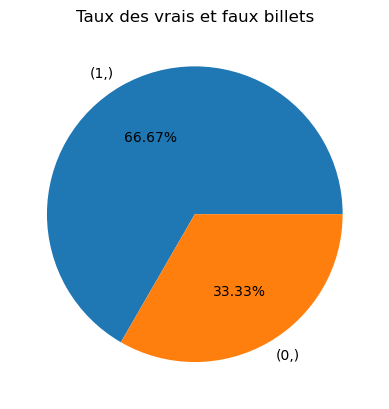

In [8]:
# afficher les taux d'authencité'
billets[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux des vrais et faux billets')

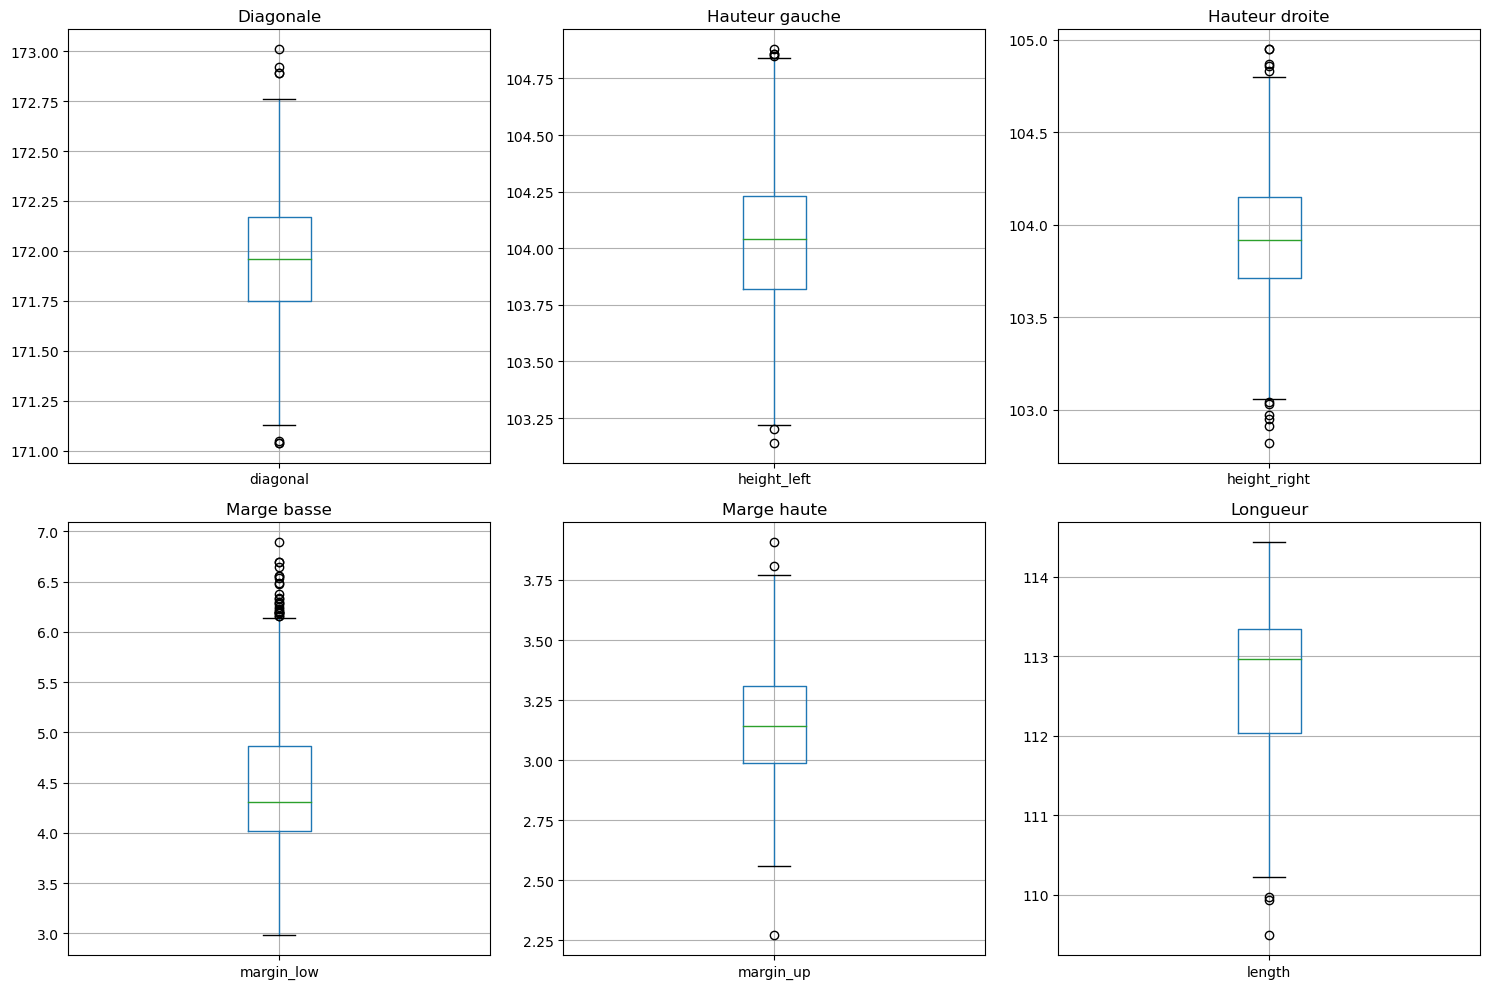

In [9]:
# Boxplots pour visu de la distribution et des outliers
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
billets.boxplot(column='diagonal')
plt.title('Diagonale')

plt.subplot(2, 3, 4)
billets.boxplot(column='margin_low')
plt.title('Marge basse')

plt.subplot(2, 3, 2)
billets.boxplot(column='height_left')
plt.title('Hauteur gauche')

plt.subplot(2, 3, 3)
billets.boxplot(column='height_right')
plt.title('Hauteur droite')

plt.subplot(2, 3, 5)
billets.boxplot(column='margin_up')
plt.title('Marge haute')

plt.subplot(2, 3, 6)
billets.boxplot(column='length')
plt.title('Longueur')

plt.tight_layout()
plt.show()

In [10]:
# Recherche de la nature des Nan pour choisir le traitement
valeurs_manquantes_margin_low = billets['margin_low'].isna()
(billets[valeurs_manquantes_margin_low])


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72             1    171.94       103.89        103.45         NaN       3.25   
99             1    171.93       104.07        104.18         NaN       3.14   
151            1    172.07       103.80        104.38         NaN       3.02   
197            1    171.45       103.66        103.80         NaN       3.62   
241            1    171.83       104.14        104.06         NaN       3.02   
251            1    171.80       103.26        102.82         NaN       2.95   
284            1    171.92       103.83        103.76         NaN       3.23   
334            1    171.85       103.70        103.96         NaN       3.00   
410            1    172.56       103.72        103.51         NaN       3.12   
413            1    172.30       103.66        103.50         NaN       3.16   
445            1    172.34       104.42        103.22         NaN       3.01   
481            1    171.81       103.53        103.96         NaN       2.71   
505            1    172.01       103.97        104.05         NaN       2.98   
611            1    171.80       103.68        103.49         NaN       3.30   
654            1    171.97       103.69        103.54         NaN       2.70   
675            1    171.60       103.85        103.91         NaN       2.56   
710            1    172.03       103.97        103.86         NaN       3.07   
739            1    172.07       103.74        103.76         NaN       3.09   
742            1    172.14       104.06        103.96         NaN       3.24   
780            1    172.41       103.95        103.79         NaN       3.13   
798            1    171.96       103.84        103.62         NaN       3.01   
844            1    171.62       104.14        104.49         NaN       2.99   
845            1    172.02       104.21        104.05         NaN       2.90   
871            1    171.37       104.07        103.75         NaN       3.07   
895            1    171.81       103.68        103.80         NaN       2.98   
919            1    171.92       103.68        103.45         NaN       2.58   
945            1    172.09       103.74        103.52         NaN       3.02   
946            1    171.63       103.87        104.66         NaN       3.27   
981            1    172.02       104.23        103.72         NaN       2.99   
1076           0    171.57       104.27        104.44         NaN       3.21   
1121           0    171.40       104.38        104.19         NaN       3.17   
1176           0    171.59       104.05        103.94         NaN       3.02   
1303           0    172.17       104.49        103.76         NaN       2.93   
1315           0    172.08       104.15        104.17         NaN       3.40   
1347           0    171.72       104.46        104.12         NaN       3.61   
1435           0    172.66       104.33        104.41         NaN       3.56   
1438           0    171.90       104.28        104.29         NaN       3.24   

      length  
72    112.79  
99    113.08  
151   112.93  
197   113.27  
241   112.36  
251   113.22  
284   113.29  
334   113.36  
410   112.95  
413   112.95  
445   112.97  
481   113.99  
505   113.65  
611   112.84  
654   112.79  
675   113.27  
710   112.65  
739   112.41  
742   113.07  
780   113.41  
798   114.44  
844   113.35  
845   113.62  
871   113.27  
895   113.82  
919   113.68  
945   112.78  
946   112.68  
981   113.37  
1076  111.87  
1121  112.39  
1176  111.29  
1303  111.21  
1315  112.29  
1347  110.31  
1435  111.47  
1438  111.49

In [11]:
billets.describe()

is_genuine     diagonal  height_left  height_right   margin_low  \
count  1500.000000  1500.000000  1500.000000   1500.000000  1463.000000   
mean      0.666667   171.958440   104.029533    103.920307     4.485967   
std       0.471562     0.305195     0.299462      0.325627     0.663813   
min       0.000000   171.040000   103.140000    102.820000     2.980000   
25%       0.000000   171.750000   103.820000    103.710000     4.015000   
50%       1.000000   171.960000   104.040000    103.920000     4.310000   
75%       1.000000   172.170000   104.230000    104.150000     4.870000   
max       1.000000   173.010000   104.880000    104.950000     6.900000   

         margin_up      length  
count  1500.000000  1500.00000  
mean      3.151473   112.67850  
std       0.231813     0.87273  
min       2.270000   109.49000  
25%       2.990000   112.03000  
50%       3.140000   112.96000  
75%       3.310000   113.34000  
max       3.910000   114.44000

## B. EXPLORATION

### Corrélation entre les variables

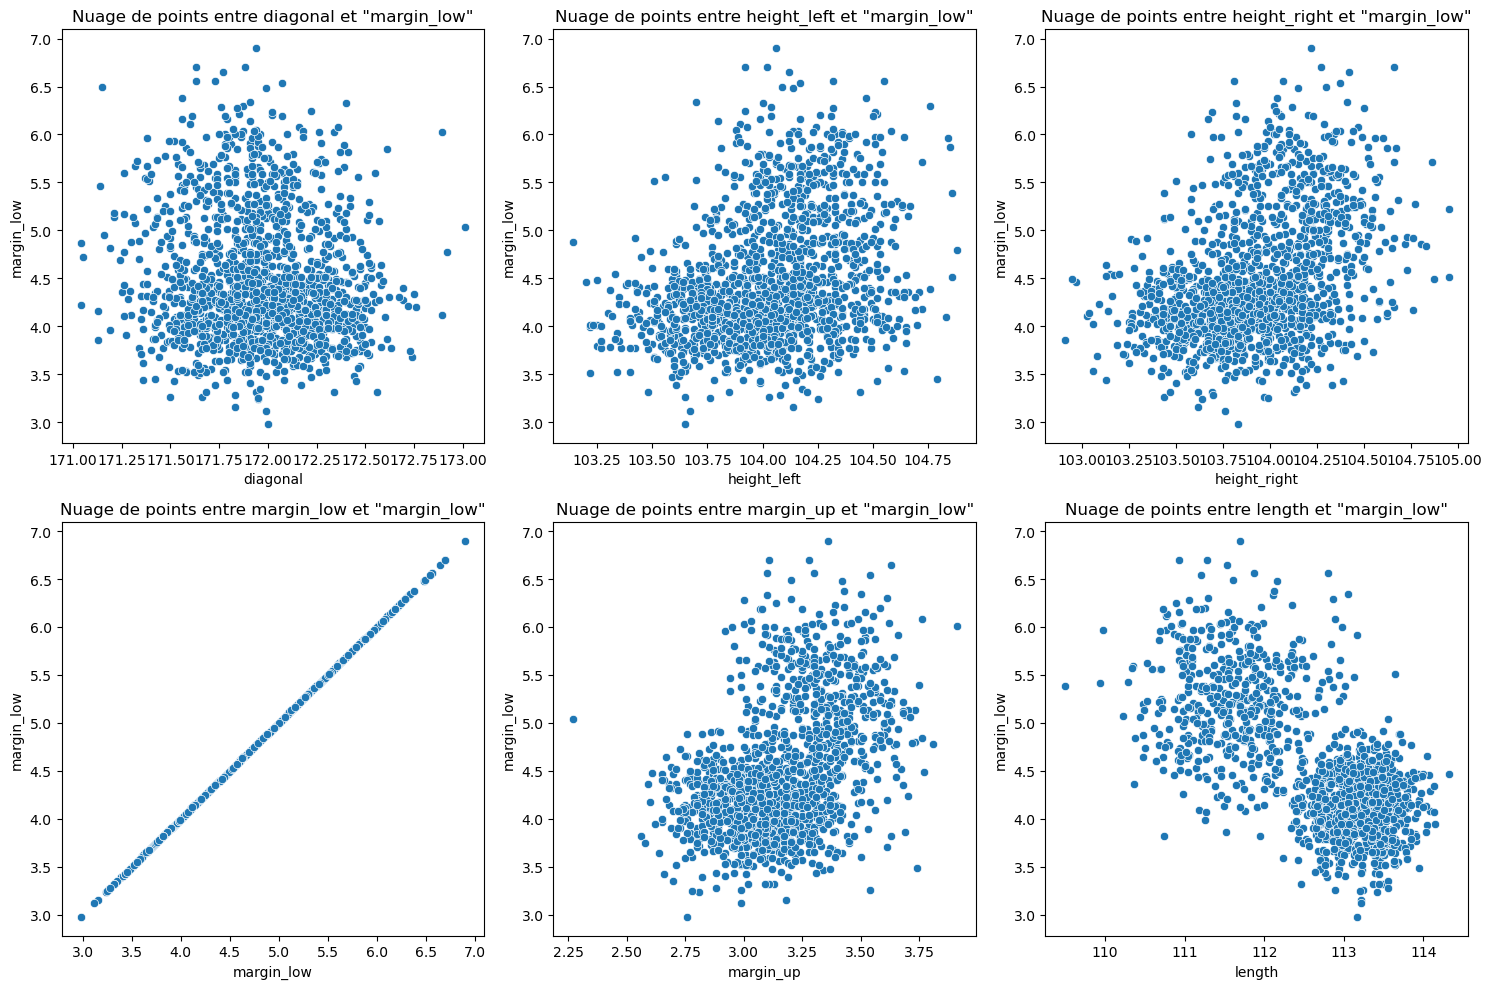

In [12]:
# Extraction des colonnes de variables explicatives
X = billets.drop('is_genuine', axis=1)

# Déterminer le nombre de colonnes pour afficher les graphiques
num_cols = len(X.columns)

# Calculer le nombre de lignes nécessaire
num_rows = (num_cols + 2) // 3 

# Définir la taille de la figure en fonction du nombre de lignes
plt.figure(figsize=(15, num_rows * 5))

# Boucle pour tracer les nuages de points pour chaque variable explicative
for i, col in enumerate(X.columns):
    plt.subplot(num_rows, 3, i+1)  # Positionner chaque nuage de points
    sns.scatterplot(x=X[col], y=billets["margin_low"])
    plt.title(f'Nuage de points entre {col} et "margin_low"')
    plt.xlabel(col)
    plt.ylabel('margin_low')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()


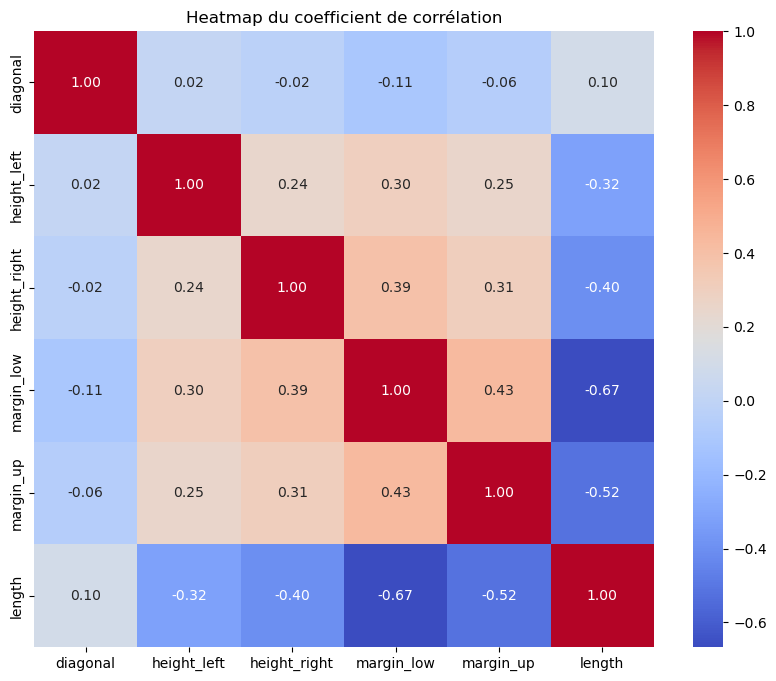

In [13]:
# billets_features
billets_features = billets.drop('is_genuine', axis=1)

# Heatmap du coefficient de corrélation de billets_features
plt.figure(figsize=(10, 8))
sns.heatmap(billets_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap du coefficient de corrélation')
plt.show()


In [14]:
# Calculer la matrice de corrélation
corr_matrix = billets_features.corr()

# Filtrer les variables corrélées entre 0.6 et 0.9
corr_threshold_min = 0.6
corr_threshold_max = 0.9
correlated_vars = corr_matrix[((corr_matrix >= corr_threshold_min) & (corr_matrix < corr_threshold_max)) | ((corr_matrix <= -corr_threshold_min) & (corr_matrix > -corr_threshold_max))].stack().index.tolist()

# Afficher les paires de variables corrélées
print("Paires de variables corrélées entre 0.6 et 0.9 :")
for var1, var2 in correlated_vars:
    print(f"{var1} - {var2}")


Paires de variables corrélées entre 0.6 et 0.9 :
margin_low - length
length - margin_low


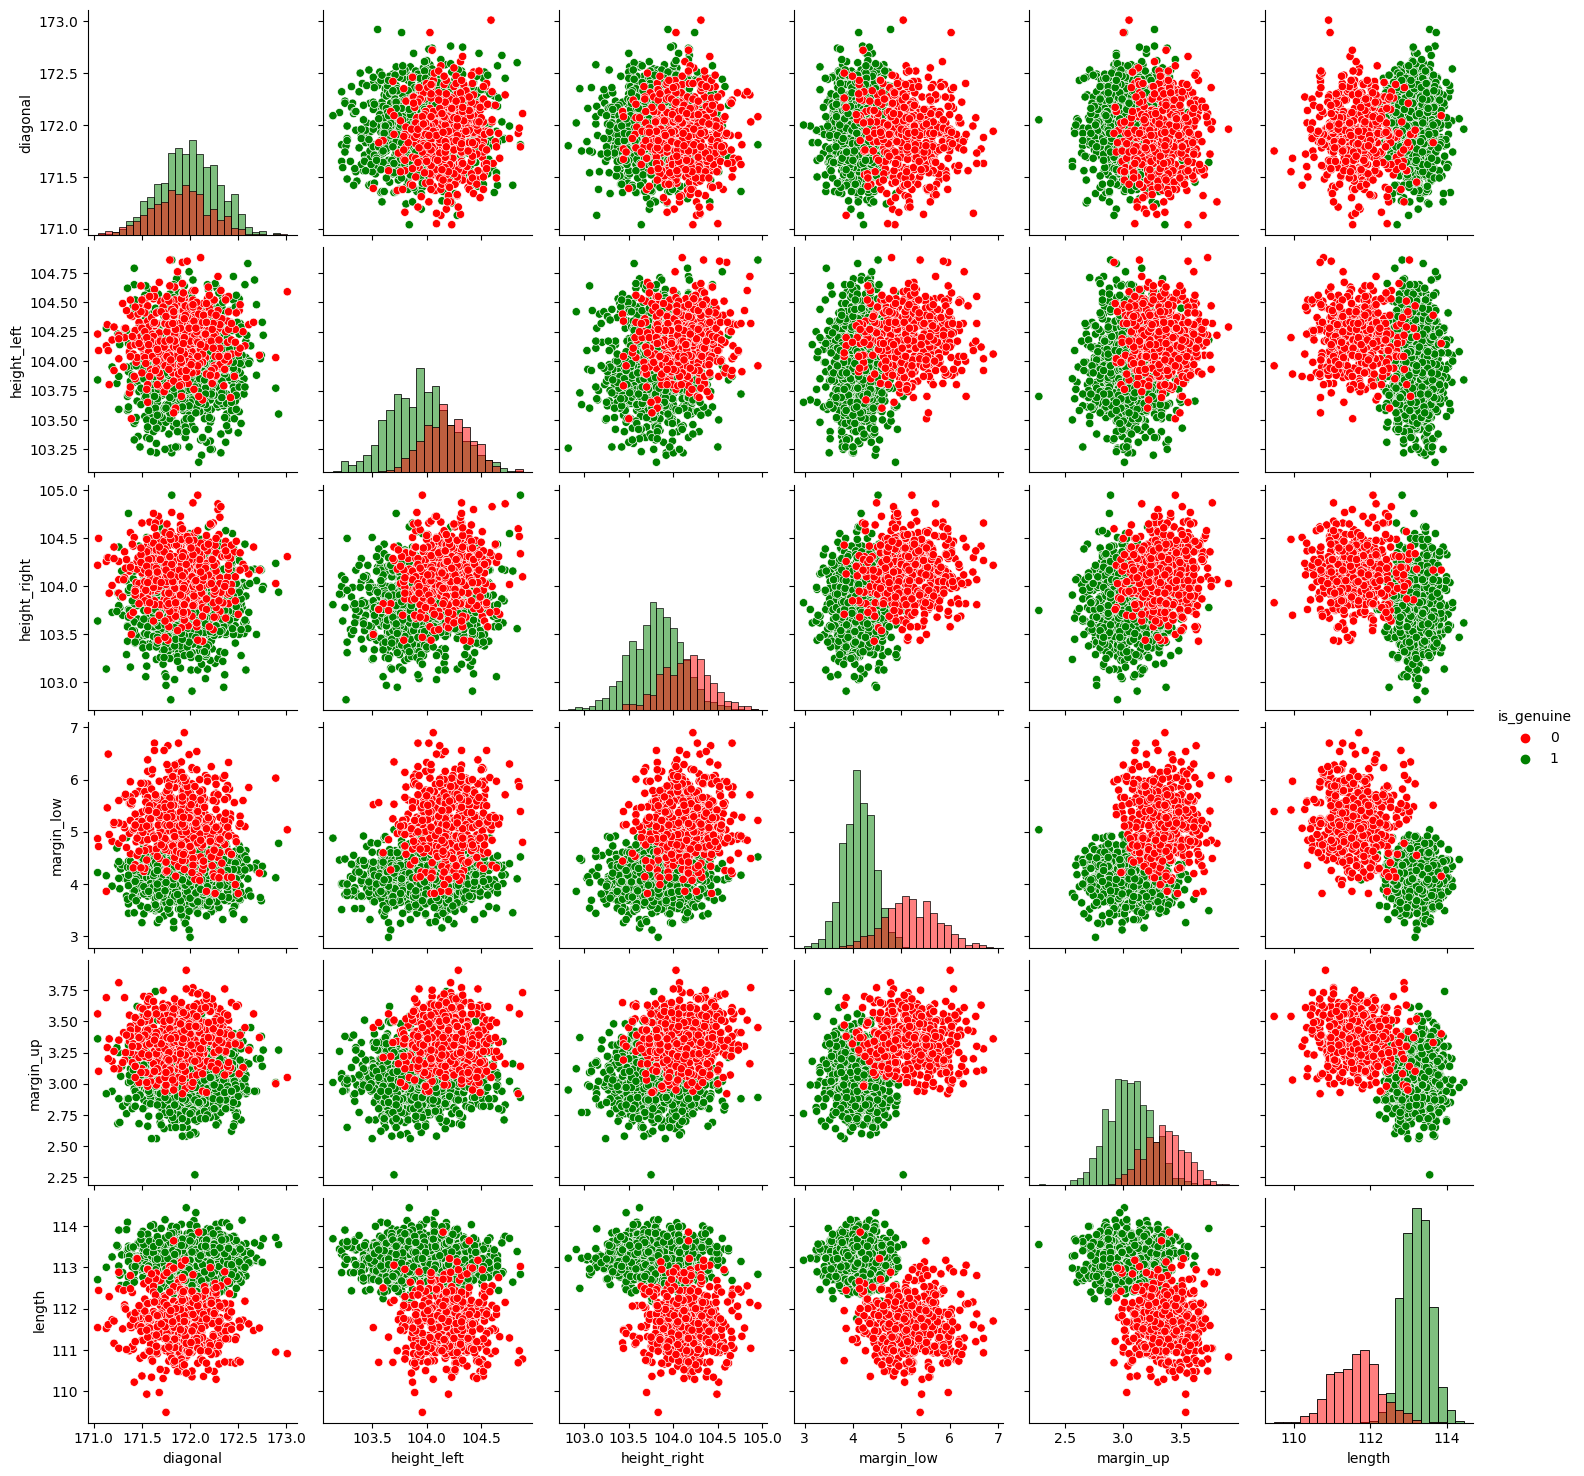

In [15]:
palette = {True: 'green', False: 'red'}
# Créer le pairplot avec distinction par la variable is_genuine
sns.pairplot(billets, vars=X, hue='is_genuine', diag_kind='hist', palette=palette) 
plt.show()

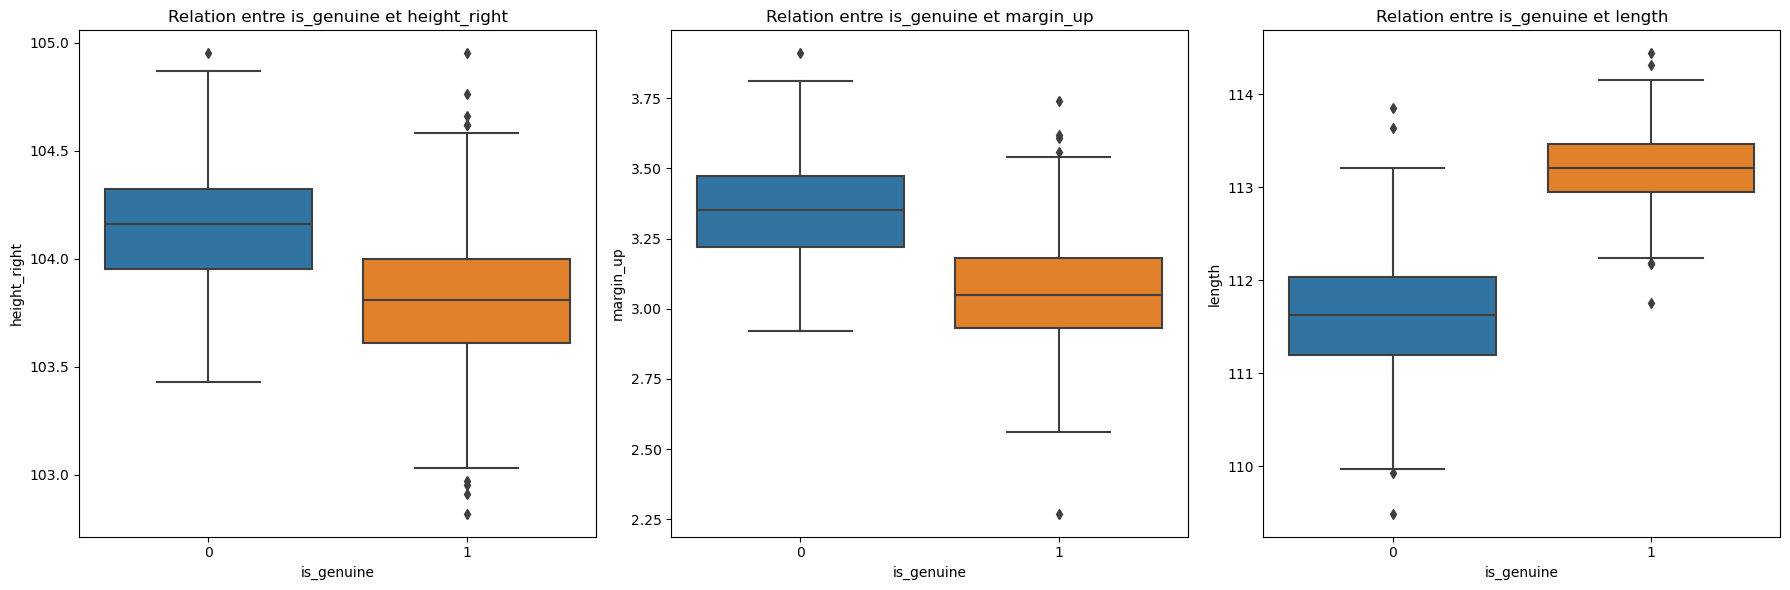

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot relation entre is_genuine et margin_low
sns.boxplot(ax=axes[0], x='is_genuine', y='height_right', data=billets)
axes[0].set_xlabel('is_genuine')
axes[0].set_ylabel('height_right')
axes[0].set_title('Relation entre is_genuine et height_right')

# Boxplot relation entre is_genuine et margin_up
sns.boxplot(ax=axes[1], x='is_genuine', y='margin_up', data=billets)
axes[1].set_xlabel('is_genuine')
axes[1].set_ylabel('margin_up')
axes[1].set_title('Relation entre is_genuine et margin_up')

# Boxplot relation entre is_genuine et length
sns.boxplot(ax=axes[2], x='is_genuine', y='length', data=billets)
axes[2].set_xlabel('is_genuine')
axes[2].set_ylabel('length')
axes[2].set_title('Relation entre is_genuine et length')


plt.tight_layout()
plt.show()

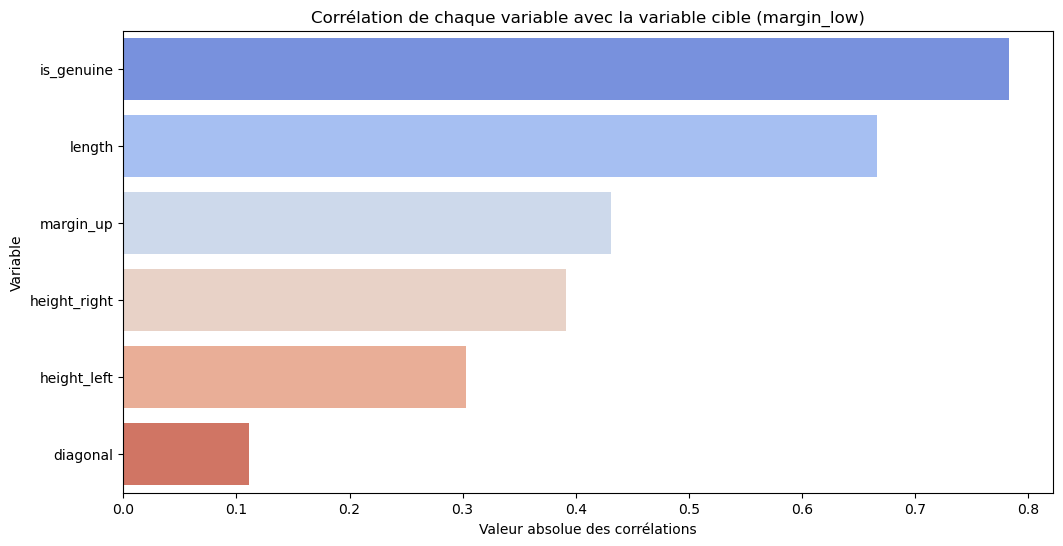

In [17]:
# Exclure la variable cible "is_genuine" utiliser .corrwith
correlations = abs(billets.drop('margin_low', axis=1).corrwith(billets['margin_low'])).sort_values(ascending=False)

# Créer le graphique
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.xlabel('Valeur absolue des corrélations')
plt.ylabel('Variable')
plt.title('Corrélation de chaque variable avec la variable cible (margin_low)')
plt.show()


### 2. Traitement des valeurs manquantes

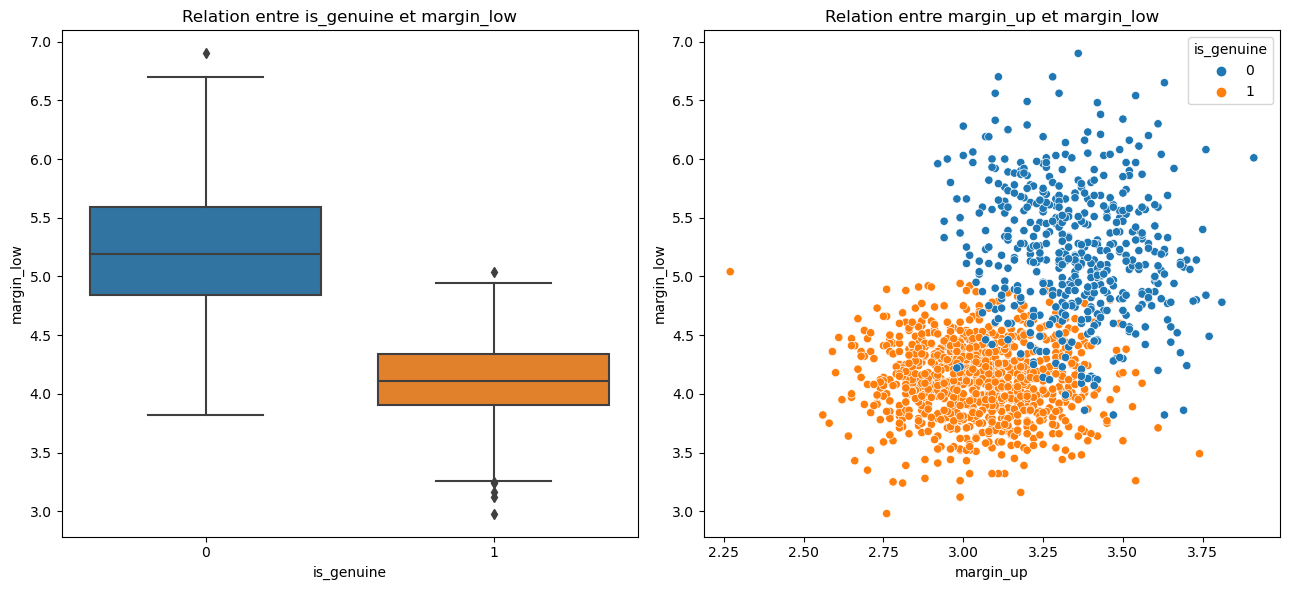

In [18]:
# Liste des variables explicatives par rapport à margin_low
features = ['margin_up', 'is_genuine']
# Configuration de la figure avec deux subplots côte à côte
plt.figure(figsize=(13, 6))

# Boxplot pour la relation entre is_genuine et margin_low
plt.subplot(1, 2, 1)
sns.boxplot(x='is_genuine', y='margin_low', data=billets)
plt.xlabel('is_genuine')
plt.ylabel('margin_low')
plt.title('Relation entre is_genuine et margin_low')

# Tracé du scatter plot pour la relation entre margin_up et margin_low
plt.subplot(1, 2, 2)
sns.scatterplot(x='margin_up', y='margin_low',hue='is_genuine', data=billets)
plt.xlabel('margin_up')
plt.ylabel('margin_low')
plt.title('Relation entre margin_up et margin_low')

# Afficher la figure
plt.tight_layout()
plt.show()

### Régression linéaire

#### 1. Division du dataframe et Modélisation des données sur le 'train'

In [19]:
# On créé un Dataset avec les individus qui ont un margin_low = NaN 
train_df = billets.dropna(subset=['margin_low'])
# On créé un Dataset avec les valeurs manquantes
predict_df = billets[billets['margin_low'].isna()]

Results du backward selection margin_low ~ is_genuine + margin_up + 1
is the final model ! Mais je me base aussi sur les visualisations précedentes pour déterminer les variables explicatives.

In [20]:
# Sélectionner les variables explicatives (X) et la variable cible (y)
features = ['margin_up', 'is_genuine']# d apres les visus precédentes 
target = 'margin_low'

X = train_df[features]
X = sm.add_constant(X)  # Ajouter une constante pour l'estimation des coefficients
y = train_df[target]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle de régression linéaire sur l'ensemble d'entraînement
model = sm.OLS(y_train, X_train).fit()

# Afficher les résultats de la régression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     886.1
Date:                Thu, 06 Jun 2024   Prob (F-statistic):          8.27e-235
Time:                        11:15:57   Log-Likelihood:                -646.19
No. Observations:                1170   AIC:                             1298.
Df Residuals:                    1167   BIC:                             1314.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8844      0.227     25.975      0.0

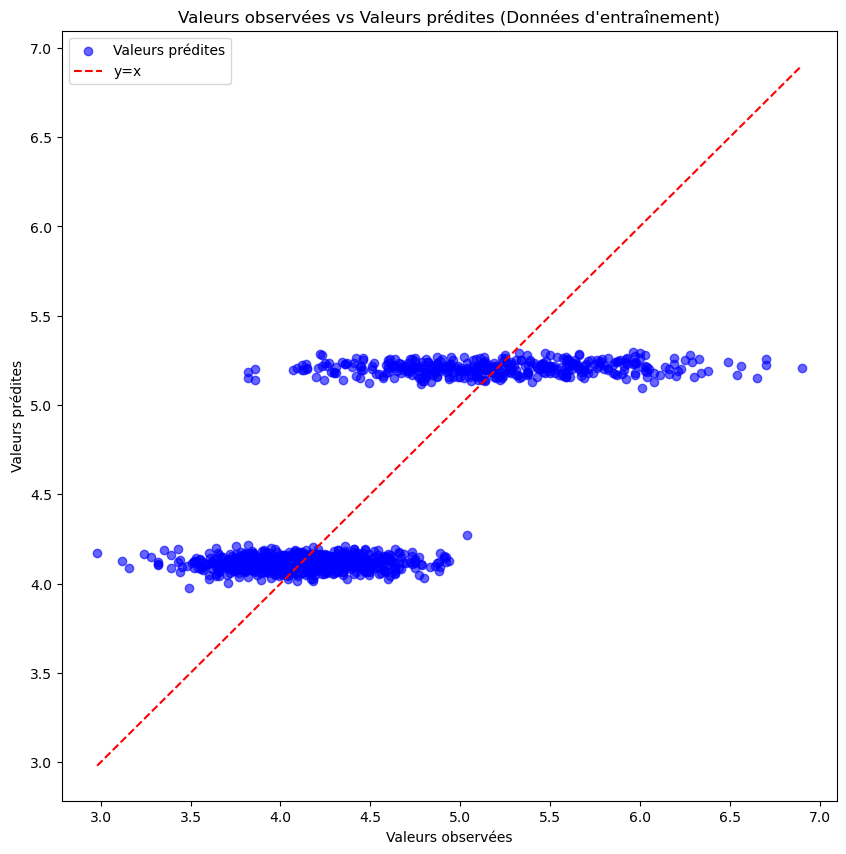

In [21]:
# Tracer les valeurs observées par rapport aux valeurs prédites sur les données d'entraînement
plt.figure(figsize=(10, 10))
plt.scatter(y_train, model.predict(X_train), color='blue', alpha=0.6, label='Valeurs prédites')
plt.xlabel('Valeurs observées')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs observées vs Valeurs prédites (Données d\'entraînement)')

# Tracer la ligne y=x en rouge pour référence
min_val = min(min(y_train), min(model.predict(X_train)))
max_val = max(max(y_train), max(model.predict(X_train)))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x')

plt.legend()
plt.show()


#### 2.Vérification des hypothèses
Avant de valider l'utilisation de la régression linéaire, nous devons vérifier plusieurs hypothèses afin de s'assurer que nous pouvons appliquer cette régression. Voici les hypothèses à vérifier :


#### Hypothése normalité des résidus
Normalité : Les erreurs résiduelles doivent être distribuées normalement. Cela signifie que les résidus doivent suivre une distribution normale avec une moyenne de zéro.

Moyenne des résidus: 9.804123325151382e-15


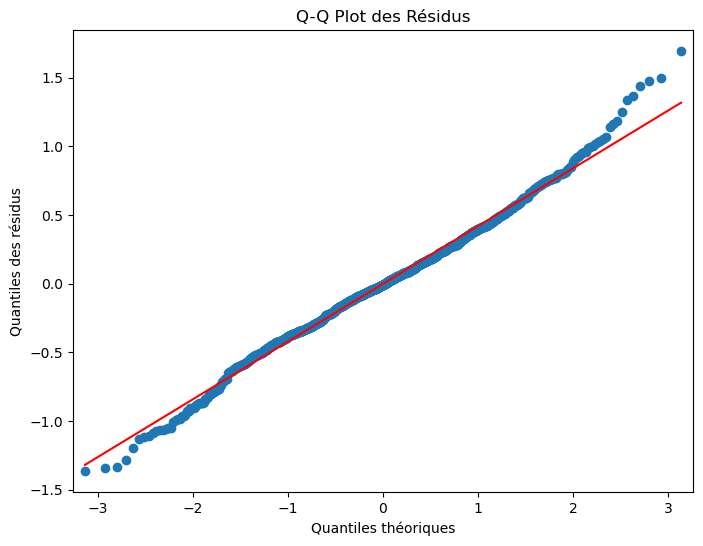

In [22]:
# Calculer les résidus
y_pred = model.predict(X_train)
residuals = y_train - y_pred

# Afficher la moyenne des résidus (devrait être proche de 0)
print("Moyenne des résidus:", residuals.mean())

# QQ-plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('Q-Q Plot des Résidus')
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles des résidus')
plt.show()



Moyenne des résidus proche de 0 VALIDE

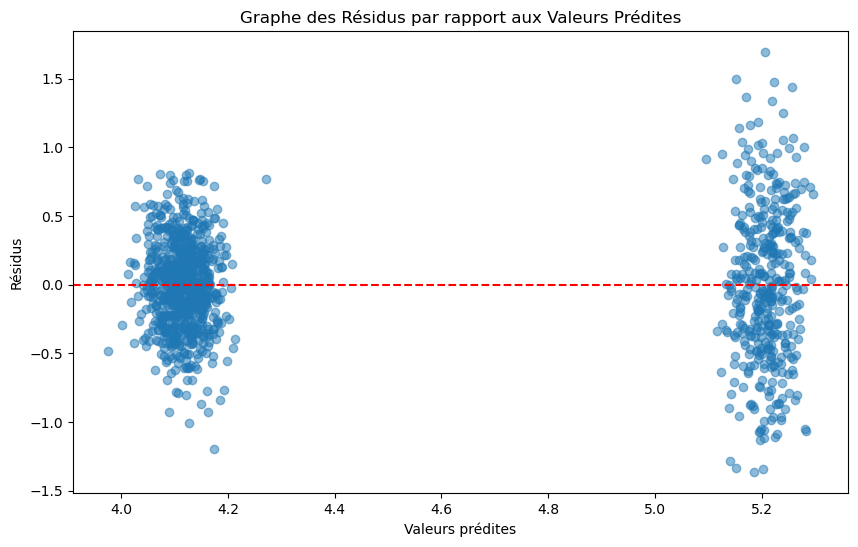

In [23]:
# Tracer le graphe des résidus par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Graphe des Résidus par rapport aux Valeurs Prédites')
plt.show()


#### .Hypothése de normalité Test de Shapiro Wilk
Les erreurs résiduelles doivent être distribuées normalement. Cela signifie que les résidus doivent suivre une distribution normale avec une moyenne de zéro.

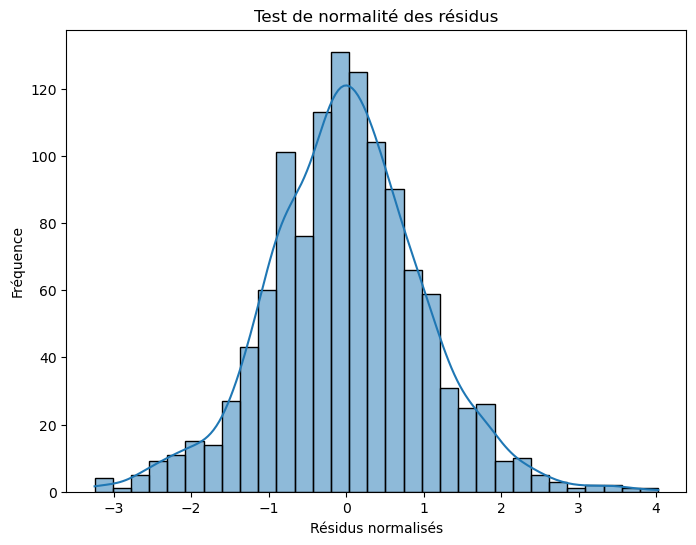

In [24]:
# Obtenir les résidus normalisés Si un résidu studentisé interne est supérieur à 2 verif outliers
resid_norm = model.get_influence().resid_studentized_internal

# Tracer l'histogramme des résidus normalisés
plt.figure(figsize=(8, 6))
sns.histplot(resid_norm, kde=True)
plt.title('Test de normalité des résidus')
plt.xlabel('Résidus normalisés')
plt.ylabel('Fréquence')
plt.show()


In [25]:
# Calcul du test de Shapiro-Wilk
statistic, p_value = shapiro(resid_norm)

# Affichage des résultats
print("Test de Shapiro-Wilk pour la normalité des résidus:")
print(f"Statistique de test: {statistic:.4f}")
print(f"P-value : {p_value:.4f}")

# Interprétation des résultats en fonction de la valeur p
if p_value < 0.05:
    print("Le test indique que les résidus ne suivent pas une distribution normale (hypothèse rejetée).")
else:
    print("Conclusion: Les résidus semblent suivre une distribution normale (hypothèse non rejetée).")



Test de Shapiro-Wilk pour la normalité des résidus:
Statistique de test: 0.9931
P-value : 0.0000
Le test indique que les résidus ne suivent pas une distribution normale (hypothèse rejetée).


#### .Hypothèse de l'homoscédasticité des résidus
L'homoscédasticité signifie que la variance des erreurs résiduelles est constante à tous les niveaux de la variable prédite.

In [26]:
# Récupération des valeurs prédites
predicted = model.fittedvalues

# Division des résidus en groupes en fonction des valeurs prédites
groups = pd.qcut(predicted, q=5, labels=False)

# Test de Levene sur les résidus groupés
grouped_residuals = [residuals[groups == i] for i in np.unique(groups)]
levene_test = levene(*grouped_residuals, center='mean')

# Récupération de la statistique de test et de la valeur p
test_statistic, p_value = levene_test.statistic, levene_test.pvalue

# Affichage des résultats
print("Test de Levene:")
print(f"Statistique de test: {test_statistic:.4f}")
print(f"Valeur p: {p_value:.4e}")

# Interprétation des résultats en fonction de la valeur p
if p_value < 0.05:
    print("Conclusion: Les variances des résidus sont différentes entre les groupes (rejeter H0).")
else:
    print("Conclusion: Les variances des résidus sont égales entre les groupes (ne pas rejeter H0).")

Test de Levene:
Statistique de test: 38.8957
Valeur p: 1.3542e-30
Conclusion: Les variances des résidus sont différentes entre les groupes (rejeter H0).


In [27]:
import statsmodels.stats.api as sms

# Effectuer le test de Breusch-Pagan
test_statistic, p_value, _, _ = sms.het_breuschpagan(residuals, model.model.exog)

print('Test de Breusch-Pagan:')
print('Statistique de test:', test_statistic)
print('Valeur p:', p_value)

# Interprétation des résultats
if p_value < 0.05:
    print("Conclusion: La valeur p est inférieure à 0.05.")
    print("On rejette H0: Les résidus ne sont pas homoscédastiques.")
else:
    print("Conclusion: La valeur p est supérieure à 0.05.")
    print("On n'accepte pas H1: Les résidus sont homoscédastiques.")


Test de Breusch-Pagan:
Statistique de test: 147.01551502316974
Valeur p: 1.1912050767109612e-32
Conclusion: La valeur p est inférieure à 0.05.
On rejette H0: Les résidus ne sont pas homoscédastiques.


l'hétéroscedasticité semble être présente dans les résidus malgre méthodes explorées des moindres carrés

#### . Hypothèse de Multicolinéarité
Cette hypothèse concerne la relation entre les variables prédictives (ou indépendantes) dans notre modèle de régression. Elle stipule qu'il ne devrait pas y avoir de forte corrélation linéaire entre les variables indépendantes.

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcul des facteurs VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif


VIF Factor
0  338.926386
1    1.640983
2    1.640983

In [29]:
from statsmodels.stats.stattools import durbin_watson
# Test d'autocorrélation si sup 2.5 auto corré
dw_stat = durbin_watson(model.resid)
print("Test de Durbin-Watson : statistique = %f" % dw_stat)
# Interprétation de la statistique de Durbin-Watson
if dw_stat < 1.5:
    print("Conclusion: Autocorrélation positive des résidus.")
elif 1.5 <= dw_stat <= 2.5:
    print("Conclusion: Pas d'autocorrélation des résidus.")
else:
    print("Conclusion: Autocorrélation négative des résidus.")

Test de Durbin-Watson : statistique = 2.023409
Conclusion: Pas d'autocorrélation des résidus.


In [30]:
resid_norm.mean()

2.1157566942823784e-05

### 3. REGRESSION LINEAIRE Etape Test

In [31]:
# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)
# Calculer MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE:", mape)

MAPE: 6.504068673145758


In [32]:
# Obtention des prédictions et des métriques d'évaluation
y_train_pred = model.predict(sm.add_constant(X_train))
y_test_pred = model.predict(sm.add_constant(X_test))
r2_train = r2_score(y_test, y_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
# Construction du tableau de résultats
df_metrics = pd.DataFrame({
    'Métriques': ['R2', 'MSE', 'RMSE'],
    'Train': [r2_train, mse_train, rmse_train],
    'Test': [r2_test, mse_test, rmse_test]
})

print(df_metrics)

  Métriques     Train      Test
0        R2  0.673621  0.673621
1       MSE  0.176704  0.137570
2      RMSE  0.420362  0.370905


### 4.Imputation

In [33]:
# 1. Sélectionnez les variables explicatives pour les valeurs manquantes
X_impute = predict_df[features]

# 2. Ajoutez une constante aux variables explicatives
X_impute = sm.add_constant(X_impute)

# 3. Prédiction des valeurs manquantes en utilisant le modèle entraîné
imputed_values = model.predict(X_impute)

# 4. Remplacement des valeurs manquantes dans predict_df par les valeurs prédites
predict_df_copy = predict_df.copy()
predict_df_copy['margin_low'] = imputed_values


In [34]:
# Concaténation de train_df et predict_df_copy pour former un DataFrame complet
df_billets = pd.concat([train_df, predict_df_copy])


In [35]:
df_billets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [36]:
# Si besoin 
df_billets.to_csv(r'C:\p9\P10\df_billets.csv', index=False)

In [37]:
df_billets.describe()

is_genuine     diagonal  height_left  height_right   margin_low  \
count  1500.000000  1500.000000  1500.000000   1500.000000  1500.000000   
mean      0.666667   171.958440   104.029533    103.920307     4.482786   
std       0.471562     0.305195     0.299462      0.325627     0.659815   
min       0.000000   171.040000   103.140000    102.820000     2.980000   
25%       0.000000   171.750000   103.820000    103.710000     4.027500   
50%       1.000000   171.960000   104.040000    103.920000     4.310000   
75%       1.000000   172.170000   104.230000    104.150000     4.870000   
max       1.000000   173.010000   104.880000    104.950000     6.900000   

         margin_up      length  
count  1500.000000  1500.00000  
mean      3.151473   112.67850  
std       0.231813     0.87273  
min       2.270000   109.49000  
25%       2.990000   112.03000  
50%       3.140000   112.96000  
75%       3.310000   113.34000  
max       3.910000   114.44000

### 5. Visualisation résultats Analyse composante principale
( non pas pour réduire la dimensionnalité )

In [38]:
# ACP
pca = PCA(svd_solver='full')
coord = pca.fit_transform(df_billets)

In [39]:
# Les variances expliquées  (Valeurs propres)
print("Variance expliquée:", pca.explained_variance_)
# Les proportions variances expliquées 
print("Proportion de variance expliquée:", pca.explained_variance_ratio_)

Variance expliquée: [1.25550953 0.18210903 0.09694871 0.08699126 0.07233805 0.04390851
 0.02417045]
Proportion de variance expliquée: [0.71255787 0.10335503 0.05502273 0.04937143 0.04105508 0.02492005
 0.01371781]


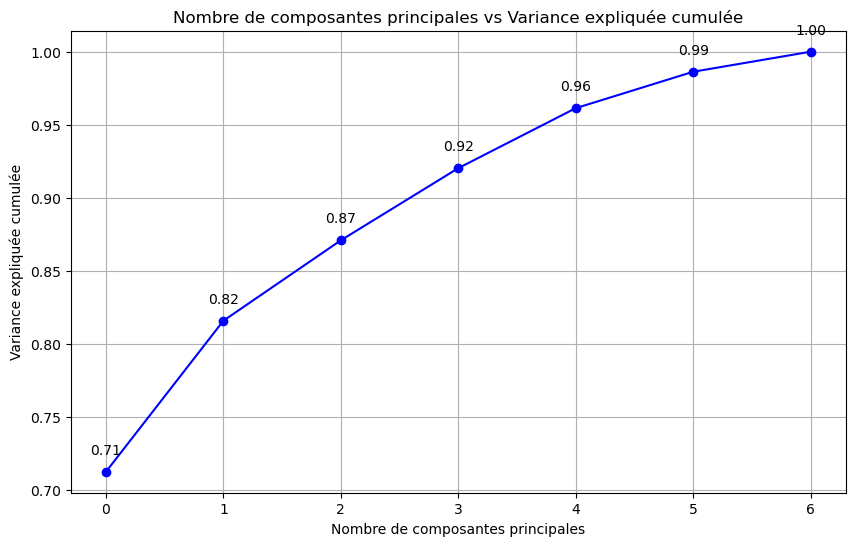

In [40]:
# Graphique de la variance expliquée cumulée pour déterminer le nombre de composantes
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='-', color='b')

# Ajouter les annotations
for i, var_ratio in enumerate(cumulative_variance_ratio):
    plt.text(i, var_ratio + 0.01, f'{var_ratio:.2f}', ha='center', va='bottom')

# Ajouter les labels et le titre
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Nombre de composantes principales vs Variance expliquée cumulée')
plt.grid(True)
plt.show()


In [96]:
# pca définir les composantes principales
pca = PCA(n_components=2).fit(df_billets)
eigval = pca.explained_variance_  # les valeurs propres de l'ACP
coord = pca.fit_transform(df_billets)

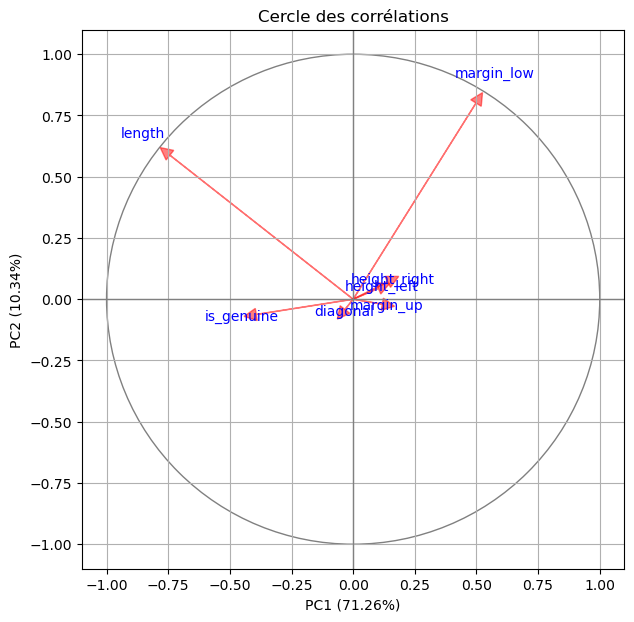

In [97]:
# Création du cercle des corrélations
fig, ax = plt.subplots(figsize=(7, 7))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax.add_artist(circle)

# Calcul des pourcentages de variance expliquée
pc1_variance = pca.explained_variance_ratio_[0] * 100
pc2_variance = pca.explained_variance_ratio_[1] * 100

# Ajout des vecteurs au cercle des corrélations
for i in range(len(df_billets.columns)):
    plt.arrow(0, 0, pca.components_.T[i, 0], pca.components_.T[i, 1],
              head_width=0.05, head_length=0.05, color='r',
              alpha=0.5)
    plt.text(pca.components_.T[i, 0] * 1.15,
             pca.components_.T[i, 1] * 1.15, 
             df_billets.columns[i], color='b', ha='center',
             va='center')

# Définition des limites et des étiquettes du graphique
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel(f'PC1 ({pc1_variance:.2f}%)')
plt.ylabel(f'PC2 ({pc2_variance:.2f}%)')
plt.title('Cercle des corrélations')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid()

# Affichage du graphique
plt.show()

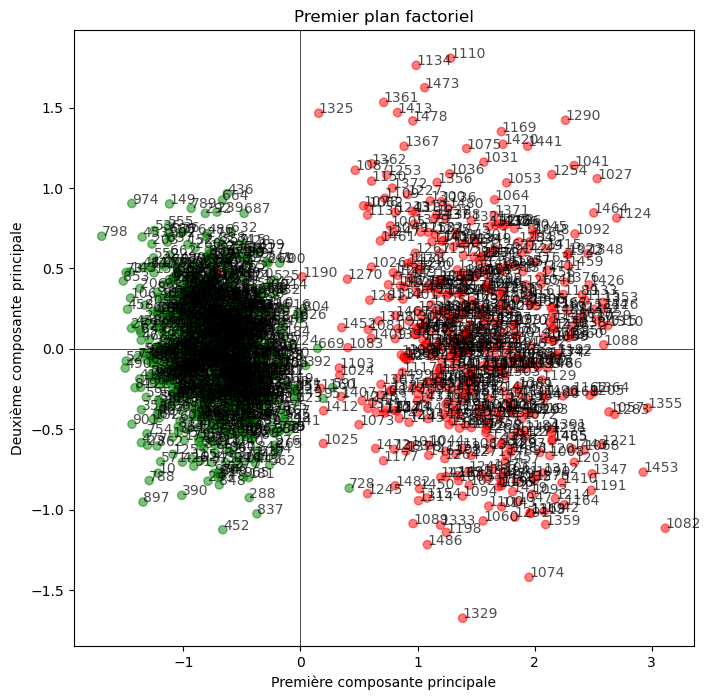

In [98]:
# Créer une liste de couleurs en fonction de la valeur de is_genuine
colors = np.where(df_billets['is_genuine'] == 1, 'green', 'red')

# Premier plan factoriel
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(coord[:, 0], coord[:, 1], alpha=0.5, c=colors)  # Utilisation des couleurs définies

# Ajouter des étiquettes pour chaque point (index)
for i, ind in enumerate(df_billets.index):
    ax.annotate(ind, (coord[i, 0], coord[i, 1]), alpha=0.7)

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax.set_xlabel('Première composante principale')
ax.set_ylabel('Deuxième composante principale')

# Titre du graphique
plt.title('Premier plan factoriel')

# Afficher le graphique
plt.show()


In [99]:
# Création d'un DataFrame avec les composantes principales
df_pca_components = pd.DataFrame(data=coord[:, :2], index=df_billets.index, columns=['PC1', 'PC2'])

In [100]:
# Ajouter la colonne is_genuine à df_pca_components
df_pca_components['is_genuine'] = df_billets['is_genuine']
# Grouper les données par la variable is_genuine
grouped_by_is_genuine = df_pca_components.groupby('is_genuine')

# Afficher les statistiques descriptives pour chaque groupe
print("Statistiques descriptives par groupe :")
grouped_by_is_genuine.describe()


Statistiques descriptives par groupe :


PC1                                                    \
             count      mean       std       min       25%       50%   
is_genuine                                                             
0            500.0  1.479106  0.540940 -0.702024  1.108778  1.452338   
1           1000.0 -0.739553  0.308664 -1.697405 -0.958675 -0.733601   

                                   PC2                                \
                 75%       max   count      mean       std       min   
is_genuine                                                             
0           1.831999  3.116446   500.0  0.034003  0.563915 -1.674463   
1          -0.529243  0.416794  1000.0 -0.017001  0.336965 -1.124057   

                                                    
                 25%       50%       75%       max  
is_genuine                                          
0          -0.367962  0.029719  0.397582  1.806482  
1          -0.239763 -0.027668  0.217950  0.965719

## C. Modélisations

## 1. Modélisation NON supervisée : K-means 

In [101]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
X = df_billets[['length','margin_low']]
y = df_billets['is_genuine']

In [103]:
# Identifier le nombre de clusters optimal
inertia_values = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

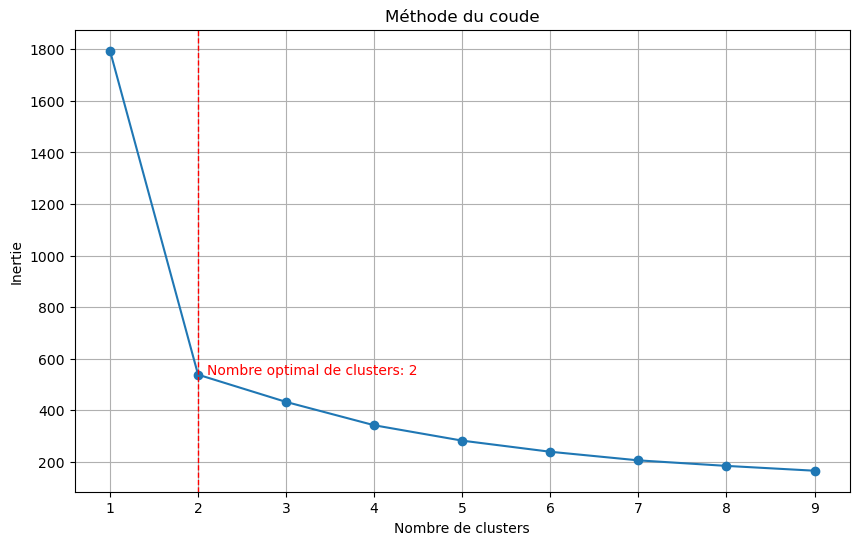

In [104]:
# Calculer la dérivée seconde de l'inertie
second_derivative = np.gradient(np.gradient(inertia_values))

# Trouver le nombre optimal de clusters
optimal_cluster_index = np.argmax(second_derivative) + 1

# Tracer le graphique d'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia_values, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')

# Ajouter une ligne verticale pour marquer le point d'inflexion
plt.axvline(x=optimal_cluster_index, color='r', linestyle='--', linewidth=1)
plt.text(optimal_cluster_index + 0.1, inertia_values[optimal_cluster_index - 1], f'Nombre optimal de clusters: {optimal_cluster_index}', color='r')

plt.grid(True)
plt.show()



In [105]:
# Instancier le modèle KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
model = kmeans.fit(X)
y_kmeans = model.fit_predict(X)
y_kmeans = 1- y_kmeans
# Récupération des clusters et des centroïdes de clusters
clusters = model.labels_
centroids = model.cluster_centers_

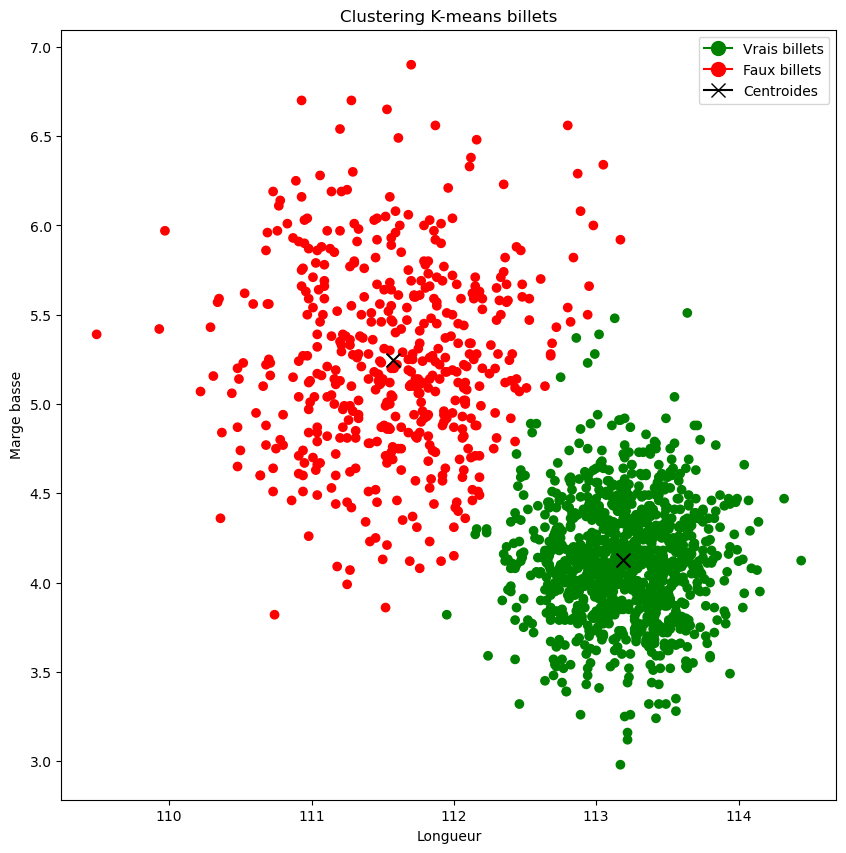

In [106]:
# Visualisation de Kmeans avec les centroides 
plt.figure(figsize=(10, 10))
colors = ['green' if label == 1 else 'red' for label in y_kmeans]
plt.scatter(X['length'], X['margin_low'], c=colors, marker='o', label='billets')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroides')
plt.legend(handles=[plt.Line2D([], [], marker='o', color='green', markersize=10, label='Vrais billets'),
                    plt.Line2D([], [], marker='o', color='red', markersize=10, label='Faux billets'),
                    plt.Line2D([], [], marker='x', color='black', markersize=10, label='Centroides')], loc='best')

plt.title('Clustering K-means billets')
plt.xlabel('Longueur')
plt.ylabel('Marge basse')

plt.show()


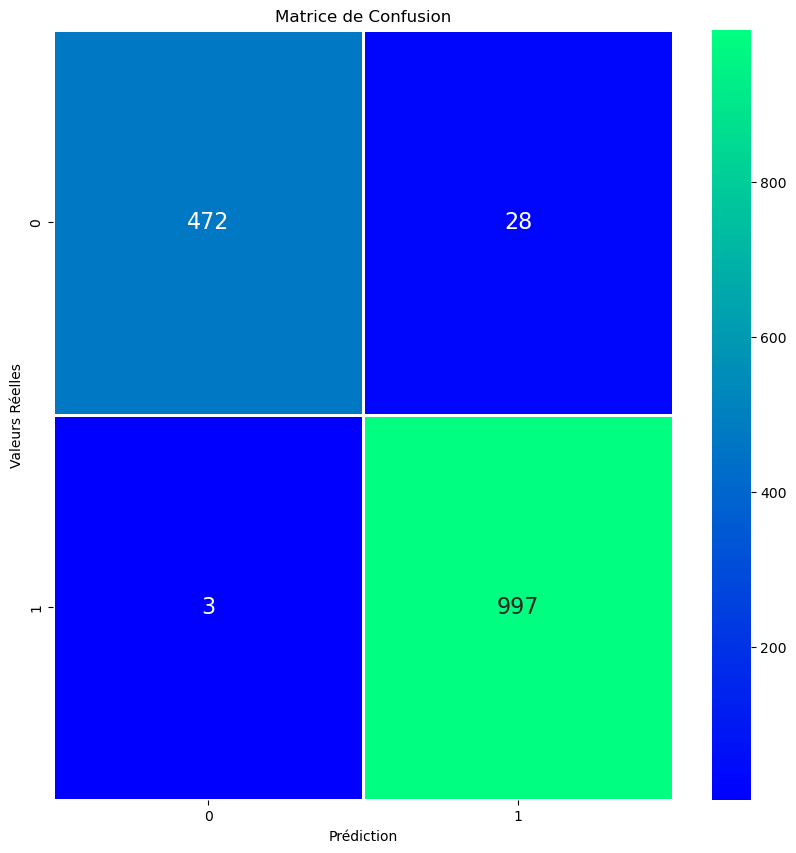

In [107]:
from sklearn.metrics import confusion_matrix
# Matrice de confusion
cm = confusion_matrix(y, y_kmeans)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', linewidths=1, annot_kws={"size": 16}, cmap='winter')
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Valeurs Réelles')
plt.show()

vn, fp, fn, vp = cm.ravel()

In [108]:
from sklearn.metrics import adjusted_rand_score
# Calcul de l'ARI
ari = adjusted_rand_score(y, y_kmeans)

# Affichage de l'ARI (échelle -1 à 1) si proche de 1 concordance parfaite 
print("Adjusted Rand Index (ARI) :", ari)

Adjusted Rand Index (ARI) : 0.9177712168076244


In [109]:
# Calcul des pourcentages
taux_vrai_positif = vp / (vp + fn)*100
taux_faux_positif = round(fp / (fp + vn)*100,2)
taux_vrai_negatif = round (vn / (vn + fp)*100,2)
taux_faux_negatif = fn / (fn + vp)*100
print(f"Vrai positif : {taux_vrai_positif}%")
print(f"Faux positif : {taux_faux_positif}%")
print(f"Vrai négatif : {taux_vrai_negatif}%")
print(f"Faux négatif : {taux_faux_negatif}%")

Vrai positif : 99.7%
Faux positif : 5.6%
Vrai négatif : 94.4%
Faux négatif : 0.3%


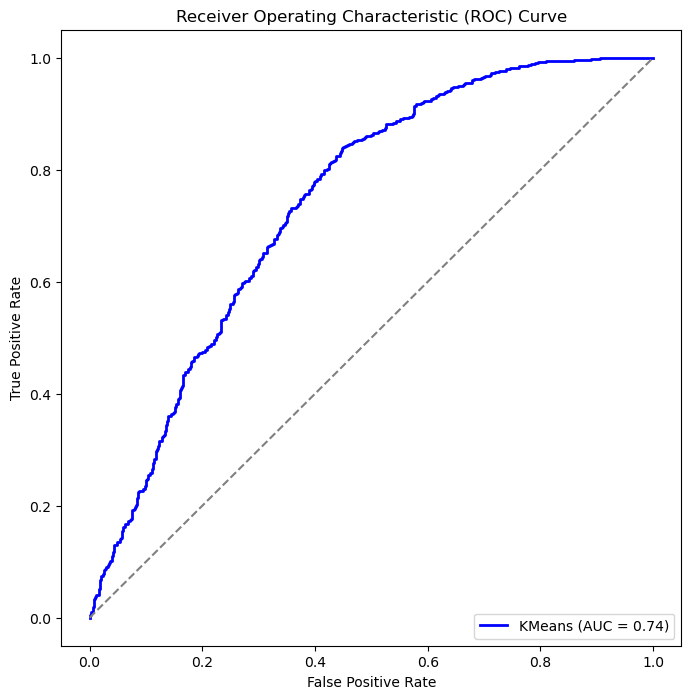

   Accuracy  Precision  Recall  F1 Score   AUC
0      0.98       0.98    0.97      0.98  0.74


In [110]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

distances = model.transform(X) 
y_scores = -distances.min(axis=1)  # Utiliser les distances minimales (inversion)
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'KMeans (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


metrics_kmeans = {
    'Accuracy': round(accuracy_score(y, y_kmeans), 2),
    'Precision': round(precision_score(y, y_kmeans, average='macro'),2),
    'Recall': round(recall_score(y, y_kmeans, average='macro'), 2),
    'F1 Score': round(f1_score(y, y_kmeans, average='macro'), 2),
    'AUC': round(roc_auc,2)
}

# Création d'un DataFrame pour les métriques
metrics_kmeans_df = pd.DataFrame([metrics_kmeans])

# Affichage du DataFrame
print(metrics_kmeans_df)


In [111]:
# Sauvegarder le modèle
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']

In [112]:
# Charger le modèle
loaded_kmeans = joblib.load('kmeans_model.pkl')

# Vérifier que le modèle est chargé correctement en prédisant de nouvelles valeurs
y_kmeans_loaded = loaded_kmeans.predict(X)

print("Modèle chargé et prédictions réalisées avec succès.")


Modèle chargé et prédictions réalisées avec succès.


## 2. Modélisation supervisée: Régression logistique 


In [113]:
# Supprimer la colonne "is_genuine"
features = df_billets.drop(columns=["is_genuine"])
scaler = StandardScaler().fit(features)
scaled_features = scaler.transform(features)


In [114]:
# features scalées
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df["is_genuine"] = df_billets["is_genuine"]
scaled_df

diagonal  height_left  height_right  margin_low  margin_up    length  \
0    -0.486540     2.774123      3.163240    0.056419  -1.128325  0.173651   
1    -1.633729    -2.236535     -0.799668   -1.080642  -0.696799  0.471666   
2     2.397823     1.504756     -1.291191   -0.125511  -0.912562  0.551901   
3    -1.961498    -0.399294      0.060498   -1.308054  -0.610494  0.953075   
4    -0.748754     0.836669     -1.414072   -0.671300   1.417677 -0.158750   
...        ...          ...           ...         ...        ...       ...   
1495  0.693427     1.538161     -0.492466    1.229419  -0.955715 -1.683213   
1496  0.398435     0.402412      0.767063    1.085762   1.072457 -0.445303   
1497 -0.781531     1.437948      0.613462    1.021574   1.978661 -2.714803   
1498  2.299493     1.003691      1.504349    1.036857   1.762898 -1.385197   
1499 -0.191548     0.836669      1.135706    1.134667   0.382015 -1.362273   

      is_genuine  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
1495           0  
1496           0  
1497           0  
1498           0  
1499           0  

[1500 rows x 7 columns]

In [115]:
scaled_df.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
is_genuine      0
dtype: int64

In [116]:
scaled_df.describe()

diagonal   height_left  height_right    margin_low     margin_up  \
count  1.500000e+03  1.500000e+03  1.500000e+03  1.500000e+03  1.500000e+03   
mean   1.464665e-14  4.812743e-14 -2.783433e-14  7.579123e-17 -1.061077e-15   
std    1.000334e+00  1.000334e+00  1.000334e+00  1.000334e+00  1.000334e+00   
min   -3.010357e+00 -2.971432e+00 -3.380166e+00 -2.278346e+00 -3.803785e+00   
25%   -6.832007e-01 -6.999333e-01 -6.460667e-01 -6.902510e-01 -6.967992e-01   
50%    5.113189e-03  3.496326e-02 -9.420867e-04 -2.619580e-01 -4.951040e-02   
75%    6.934271e-01  6.696467e-01  7.056229e-01  5.870475e-01  6.840835e-01   
max    3.446683e+00  2.840932e+00  3.163240e+00  3.664693e+00  3.273239e+00   

             length   is_genuine  
count  1.500000e+03  1500.000000  
mean   5.305386e-16     0.666667  
std    1.000334e+00     0.471562  
min   -3.654697e+00     0.000000  
25%   -7.433186e-01     0.000000  
50%    3.226587e-01     1.000000  
75%    7.582193e-01     1.000000  
max    2.019053e+00     1.000000

In [117]:
# Reg log avec SKLEARN 
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop(columns=["is_genuine"]), 
                                                    scaled_df["is_genuine"], 
                                                    test_size=0.35, 
                                                    random_state=40)


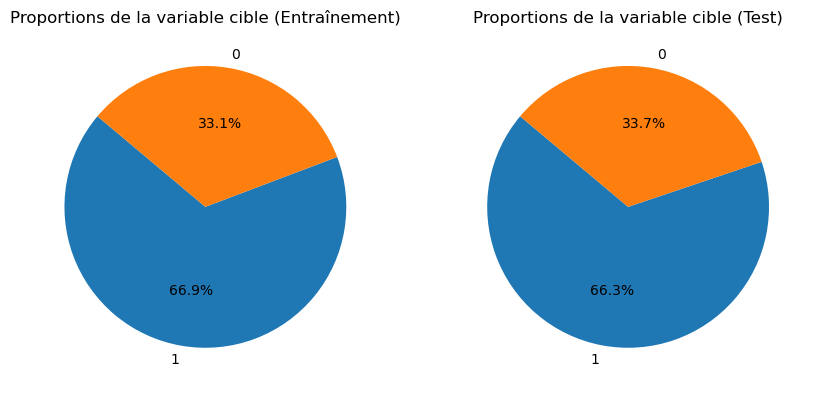

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pie(y_train.value_counts(normalize=True), labels=y_train.value_counts(normalize=True).index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Proportions de la variable cible (Entraînement)')
axes[1].pie(y_test.value_counts(normalize=True), labels=y_test.value_counts(normalize=True).index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Proportions de la variable cible (Test)')
plt.show()


In [119]:
# Créer et entraîner le modèle
model = LogisticRegression(solver='liblinear', class_weight= 'balanced')
param_grid = {'C': [0.01, 0.1, 1, 10, 100]} 
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


In [120]:
# Afficher les coefficients
coefficients = best_model.coef_[0]
features = X_train.columns
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

In [121]:
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])
coef_df

Feature  Coefficient  Odds Ratio
0      diagonal     0.231186    1.260094
1   height_left     0.003955    1.003963
2  height_right    -0.457404    0.632925
3    margin_low    -1.228035    0.292868
4     margin_up    -0.661235    0.516214
5        length     1.605407    4.979884

In [122]:
# Prédictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [123]:
"Best Parameters:", grid_search.best_params_

('Best Parameters:', {'C': 1})

In [124]:
print("Train Set Evaluation")
print("Accuracy:", round(accuracy_score(y_train, y_train_pred), 2))
print("Precision:", round(precision_score(y_train, y_train_pred), 2))
print("Recall:", round(recall_score(y_train, y_train_pred), 2))
print("F1 Score:", round(f1_score(y_train, y_train_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_train, y_train_pred), 2))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

Train Set Evaluation
Accuracy: 0.95
Precision: 0.96
Recall: 0.97
F1 Score: 0.96
ROC AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       323
           1       0.96      0.97      0.96       652

    accuracy                           0.95       975
   macro avg       0.95      0.94      0.95       975
weighted avg       0.95      0.95      0.95       975




Test Set Evaluation
Accuracy: 0.96
Precision: 0.97
Recall: 0.96
F1 Score: 0.97
ROC AUC: 0.95


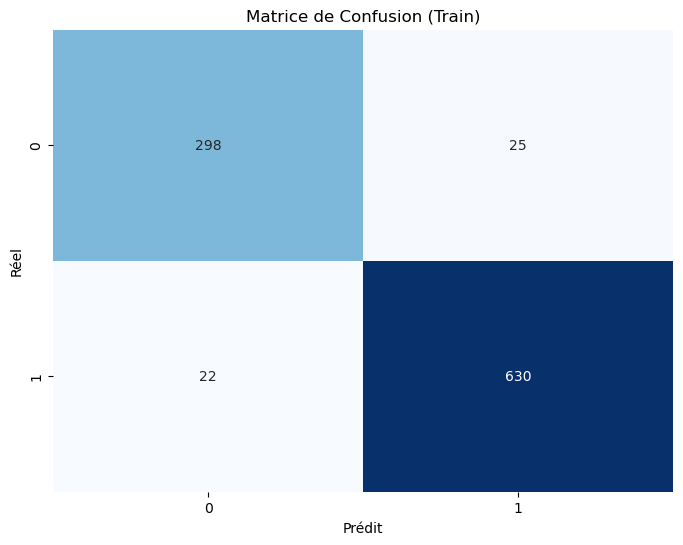

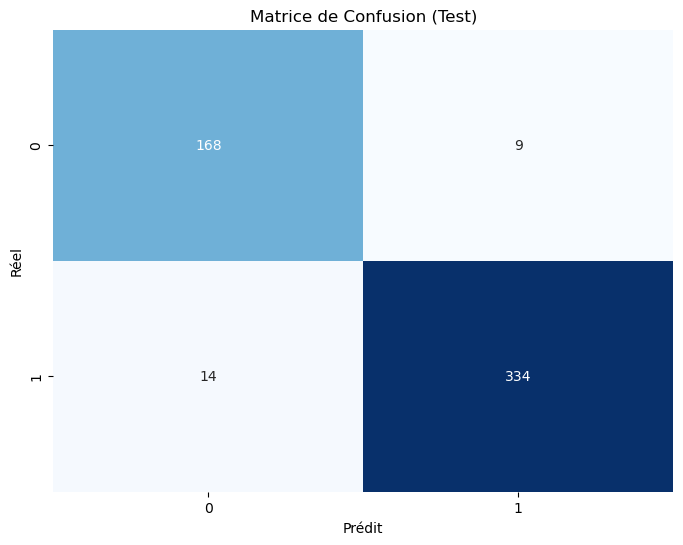

True Positives (TP): 334 (63.62%)
False Positives (FP): 9 (1.71%)
True Negatives (TN): 168 (32.00%)
False Negatives (FN): 14 (2.67%)


In [125]:
# Évaluer le modèle sur l'ensemble de test
print("\nTest Set Evaluation")
print("Accuracy:", round(accuracy_score(y_test, y_test_pred), 2))
print("Precision:", round(precision_score(y_test, y_test_pred), 2))
print("Recall:", round(recall_score(y_test, y_test_pred), 2))
print("F1 Score:", round(f1_score(y_test, y_test_pred), 2))
print("ROC AUC:", round(roc_auc_score(y_test, y_test_pred), 2))

# Fonction pour tracer la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matrice de Confusion ({set_name})')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.show()

# Tracer les matrices de confusion
plot_confusion_matrix(y_train, y_train_pred, "Train")
plot_confusion_matrix(y_test, y_test_pred, "Test")

#Pourcentages resultant test
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
# Calculer les pourcentages
total = tn + fp + fn + tp
tn_percent = tn / total * 100
fp_percent = fp / total * 100
fn_percent = fn / total * 100
tp_percent = tp / total * 100
print(f"True Positives (TP): {tp} ({tp_percent:.2f}%)")
print(f"False Positives (FP): {fp} ({fp_percent:.2f}%)")
print(f"True Negatives (TN): {tn} ({tn_percent:.2f}%)")
print(f"False Negatives (FN): {fn} ({fn_percent:.2f}%)")

In [126]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label="ROC AUC = %0.2f" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Courbe ROC ")
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.legend(loc="lower right")
    plt.show()

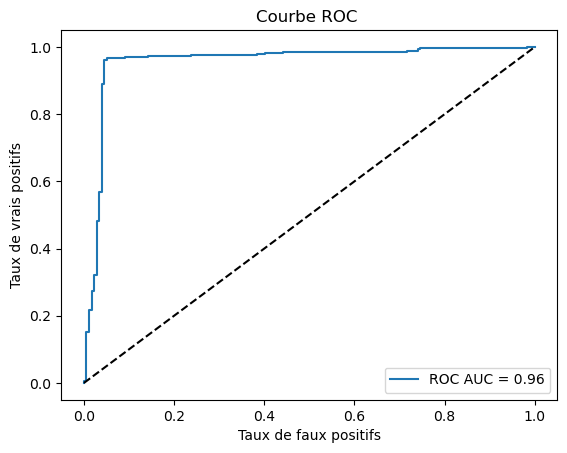

['logistic_regression_model.pkl']

In [127]:
# Tracer la courbe ROC pour l'ensemble de test
y_test_prob = best_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_test_prob)

# Sauvegarder le modèle
joblib.dump(best_model, 'logistic_regression_model.pkl')


In [128]:
# Évaluation du modèle
predictions = best_model.predict(X_test)
accuracy = round(accuracy_score(y_test, predictions), 2)
precision =round(precision_score(y_test, predictions), 2)
recall = round(recall_score(y_test, predictions), 2)
f1 = round(f1_score(y_test, predictions),2)
roc_auc =round( roc_auc_score(y_test, y_test_prob), 2)

# Afficher les métriques
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", roc_auc)

# Sauvegarder les métriques dans un DataFrame
metrics_reglog = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Value': [accuracy, precision, recall, f1, roc_auc]
}

metrics_reglog_df = pd.DataFrame(metrics_reglog)


Accuracy: 0.96
Precision: 0.97
Recall: 0.96
F1 Score: 0.97
AUC: 0.96


## 3.Méthode Supervisée "plus proches voisins" KNN
Attention sensible à la dimension des données et sensible aux variables peu importantes 

In [129]:
# Séparer les features et les labels 
X = df_billets.drop(columns='is_genuine')
y = df_billets['is_genuine']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [130]:
# Afficher les dimensions des ensembles d'entraînement et de test
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1200, 6)
X_test shape: (300, 6)
y_train shape: (1200,)
y_test shape: (300,)


In [131]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = GridSearchCV(
    KNeighborsClassifier(),  # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring='accuracy'
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [132]:
# Afficher les meilleurs hyperparamètres
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(grid_search.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 1}


In [133]:
# Afficher les résultats de la validation croisée
print("Résultats de la validation croisée :")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("accuracy = {:.3f} (+/-{:.3f}) for {}".format(mean, std * 2, params))

Résultats de la validation croisée :
accuracy = 0.946 (+/-0.024) for {'C': 0.01}
accuracy = 0.951 (+/-0.014) for {'C': 0.1}
accuracy = 0.952 (+/-0.017) for {'C': 1}
accuracy = 0.951 (+/-0.018) for {'C': 10}
accuracy = 0.951 (+/-0.018) for {'C': 100}


In [134]:
# Utiliser les meilleurs hyperparamètres pour entraîner le modèle final
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)

# Prédire les étiquettes pour les données de test
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)


In [135]:
# Calcul des métriques pour l'ensemble d'entraînement
accuracy_train = round(accuracy_score(y_train, y_train_pred), 2)
precision_train = round(precision_score(y_train, y_train_pred), 2)
recall_train = round(recall_score(y_train, y_train_pred), 2)
f1_train = round(f1_score(y_train, y_train_pred), 2)
roc_auc_train = round(roc_auc_score(y_train, y_train_pred), 2)


In [136]:
# Calcul des pourcentages de vrais positifs, faux positifs, vrais négatifs et faux négatifs pour l'ensemble d'entraînement
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
total_train = tn + fp + fn + tp
tn_percent = round(tn / total_train * 100, 2)
fp_percent = round(fp / total_train * 100, 2)
fn_percent = round(fn / total_train * 100, 2)
tp_percent = round(tp / total_train * 100, 2)

# Affichage des métriques pour l'ensemble d'entraînement
print(f'Accuracy Train: {accuracy_train}')
print(f'Precision Train: {precision_train}')
print(f'Recall Train: {recall_train}')
print(f'F1 Score Train: {f1_train}')
print(f'AUC Train: {roc_auc_train}')

# Affichage des pourcentages pour l'ensemble d'entraînement
print(f'True Positives (TP): {tp} ({tp_percent}%)')
print(f'False Positives (FP): {fp} ({fp_percent}%)')
print(f'True Negatives (TN): {tn} ({tn_percent}%)')
print(f'False Negatives (FN): {fn} ({fn_percent}%)')


Accuracy Train: 0.99
Precision Train: 0.99
Recall Train: 1.0
F1 Score Train: 0.99
AUC Train: 0.99
True Positives (TP): 796 (66.33%)
False Positives (FP): 5 (0.42%)
True Negatives (TN): 395 (32.92%)
False Negatives (FN): 4 (0.33%)


In [137]:
# Calcul des métriques pour l'ensemble de test
accuracy_test = round(accuracy_score(y_test, y_test_pred), 2)
precision_test = round(precision_score(y_test, y_test_pred), 2)
recall_test = round(recall_score(y_test, y_test_pred), 2)
f1_test = round(f1_score(y_test, y_test_pred), 2)
roc_auc_test = round(roc_auc_score(y_test, y_test_pred), 2)

# Affichage des métriques pour l'ensemble de test
print(f'Accuracy Test: {accuracy_test}')
print(f'Precision Test: {precision_test}')
print(f'Recall Test: {recall_test}')
print(f'F1 Score Test: {f1_test}')
print(f'AUC Test: {roc_auc_test}')

Accuracy Test: 0.99
Precision Test: 0.99
Recall Test: 1.0
F1 Score Test: 0.99
AUC Test: 0.99


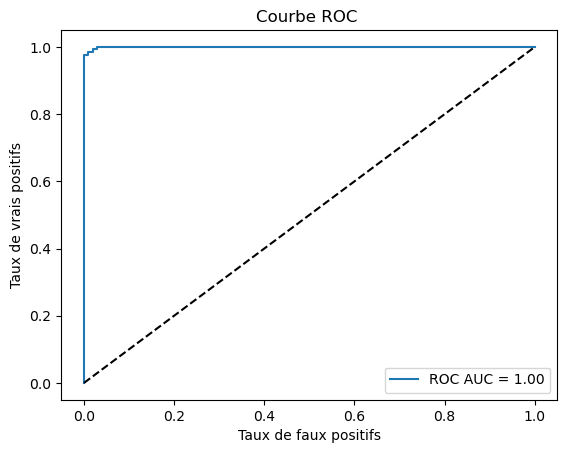

['knn_model.pkl']

In [138]:
# Tracer la courbe ROC pour l'ensemble de test
y_test_prob_knn = best_knn.predict_proba(X_test)[:, 1]  # Probabilités des classes positives
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_prob_knn)

plot_roc_curve(y_test, y_test_prob_knn)

# Sauvegarder le modèle
joblib.dump(best_knn, 'knn_model.pkl')


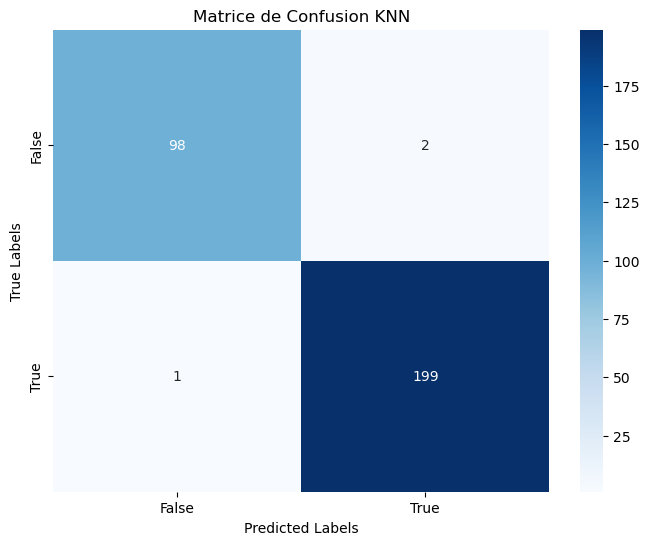

In [139]:
# Calcul et affichage de la matrice de confusion pour l'ensemble de test
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice de Confusion KNN')
plt.show()


In [140]:
# Enregistrer le modèle KNN
joblib.dump(best_knn, 'best_knn_model.pkl')

['best_knn_model.pkl']

In [141]:
metrics_knn_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Value': [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test]
})

## D.Conclusion Choix du modele

In [142]:
metrics_kmeans_df

Accuracy  Precision  Recall  F1 Score   AUC
0      0.98       0.98    0.97      0.98  0.74

In [143]:
metrics_kmeans_df = pd.DataFrame.from_dict(metrics_kmeans, orient='index', columns=['Value'])
metrics_kmeans_df

Value
Accuracy    0.98
Precision   0.98
Recall      0.97
F1 Score    0.98
AUC         0.74

In [144]:
# Création des données pour les trois modèles
models_data = {
    'Logistique': metrics_reglog_df,
    'KMeans': metrics_kmeans_df,
    'kNN': metrics_knn_df
}
# Ajouter une colonne pour indiquer le modèle
metrics_reglog_df['Model'] = 'Logistic Regression'
metrics_kmeans_df['Model'] = 'KMeans'
metrics_knn_df['Model'] = 'kNN'

# Concaténer les DataFrames
all_metrics_df = pd.concat([metrics_reglog_df, metrics_kmeans_df, metrics_knn_df])


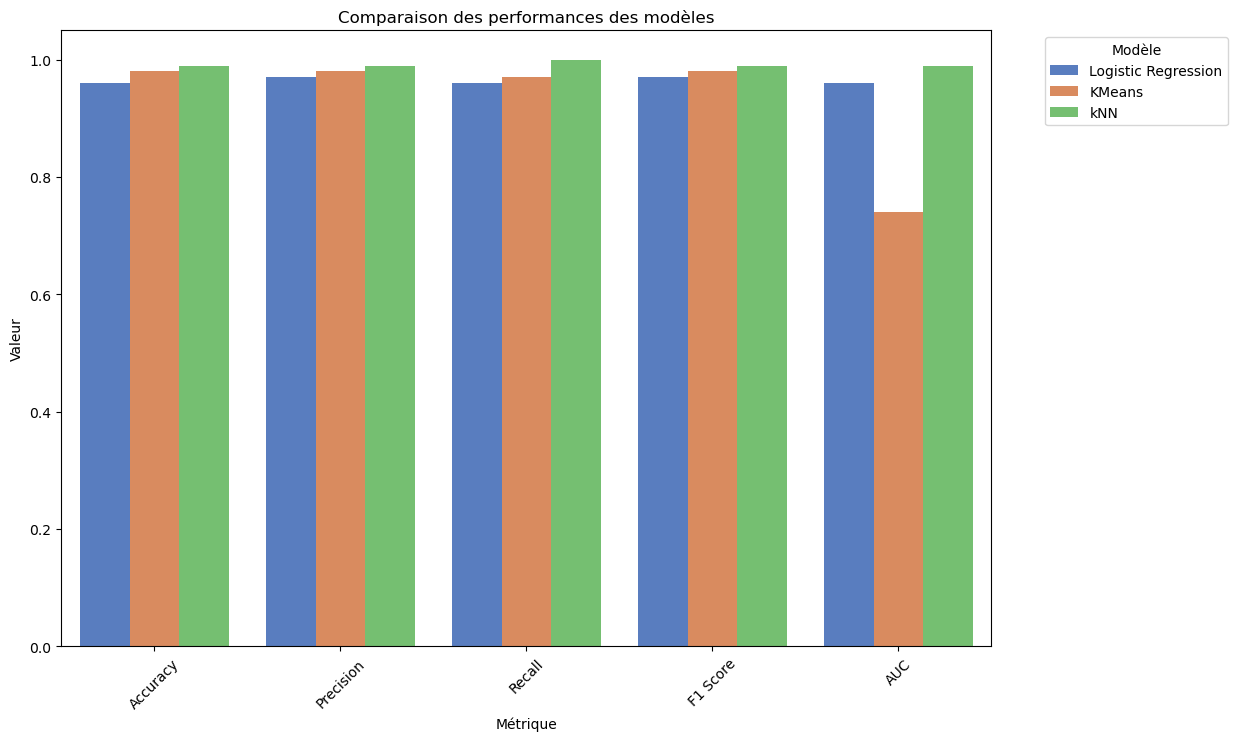

In [145]:
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'] * 3,
    'Value': [0.96, 0.97, 0.96, 0.97, 0.96, 0.98, 0.98, 0.97, 0.98, 0.74, 0.99, 0.99, 1.0, 0.99, 0.99],
    'Model': ['Logistic Regression'] * 5 + ['KMeans'] * 5 + ['kNN'] * 5
}

all_metrics_df = pd.DataFrame(data)

plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=all_metrics_df, palette='muted')
plt.title('Comparaison des performances des modèles')
plt.xlabel('Métrique')
plt.ylabel('Valeur')
plt.xticks(rotation=45)
plt.legend(title='Modèle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Deploiement du modèle 

In [146]:
path="C:/p9/P10/"

In [147]:
df=pd.read_csv(path+"billets_test.csv")
df

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5

In [148]:
def detection_faux_billets(csv_file, path,model, threshold=0.5):
    # Mettre 'id' en index
    df.set_index('id', inplace=True)
    scaler = StandardScaler()
    X = scaler.fit_transform(df)

    # Charger le modèle pré-entrainé
    model = joblib.load('knn_model.pkl')

    # Faire des prédictions
    y_prob = model.predict_proba(X)[:, 1]

    # Convertir les probabilités en classes en utilisant le seuil spécifié
    y_pred = (y_prob > threshold).astype(int)

    # Ajouter les prédictions et les probabilités au DataFrame
    df['Authenticite'] = ['Vrai' if pred == 1 else 'Faux' for pred in y_pred]
    df['Probabilite_authenticite'] = y_prob

    return df


In [149]:
detection_faux_billets(csv_file= df,path= path, model= model)

diagonal  height_left  height_right  margin_low  margin_up  length  \
id                                                                        
B_1    172.09       103.95        103.73        4.39       3.09  113.19   
B_2    171.52       104.17        104.03        5.27       3.16  111.82   
B_3    171.78       103.80        103.75        3.81       3.24  113.39   
B_4    172.02       104.08        103.99        5.57       3.30  111.10   
B_5    171.79       104.34        104.37        5.00       3.07  111.87   

    Authenticite  Probabilite_authenticite  
id                                          
B_1         Vrai                  0.999936  
B_2         Faux                  0.057443  
B_3         Vrai                  0.999959  
B_4         Faux                  0.000090  
B_5         Faux                  0.269588

In [150]:
print("Librairies utilisées :")
print("Pandas :", pd.__version__)
print("Numpy :", np.__version__)
print("Seaborn :", sns.__version__)
print("Stats models :", sm.__version__)

Librairies utilisées :
Pandas : 1.5.3
Numpy : 1.24.3
Seaborn : 0.12.2
Stats models : 0.14.0
